In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd
from sympy import Symbol
from sympy.solvers import solve
import sympy as sp

In [2]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    container['qdp_class']=q
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res


# Set experiment(s) to analyze


In [7]:
# Closed Loop dataset
#         '2018_06_15_16_01_42_Ramsey between sites'
exp_ids=[#'2018_06_15_15_14_12_Ramsey between sites',
         #'2018_06_15_16_32_36_Ramsey between sites',
         #'2018_06_15_17_12_13_Ramsey between sites',
         #'2018_06_15_17_54_00_Ramsey between sites',
         '2018_06_17_12_27_34_Open loop Ramsey, temperature controlled box',
         '2018_06_17_13_18_34_Open loop Ramsey, temperature controlled box',
         '2018_06_17_14_02_42_Open loop Ramsey, temperature controlled box',
         '2018_06_17_14_46_09_Open loop Ramsey, temperature controlled box',
         '2018_06_17_15_41_15_Open loop Ramsey, temperature controlled box',
         '2018_06_17_16_22_40_Open loop Ramsey, temperature controlled box'
]

In [8]:
assorted={}
assorted['qdp_class']=[]
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['qdp_class'].append(container['qdp_class'])
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_17/2018_06_17_12_27_34_Open loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_17/2018_06_17_13_18_34_Open loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_17/2018_06_17_14_02_42_Open loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_17/2018_06_17_14_46_09_Open loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_17/2018_06_17_15_41_15_Open loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_17/2018_06_17_16_22_40_Open loop Ramsey, temperature controlled box/

# Experiment-wise analysis

2018_06_17_12_27_34_Open loop Ramsey, temperature controlled box
0


<IPython.core.display.Javascript object>


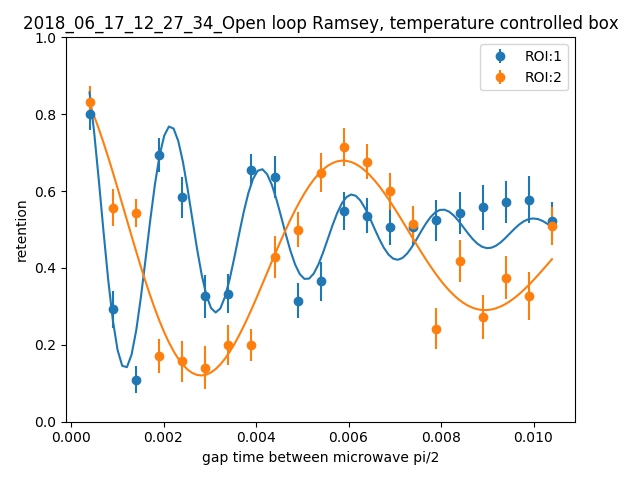

[0.017, 0.29993033521560064, 350, 1.5707963267948966, 0.5000696647843994]
tau 1  is  0.00374210934257  with 1 std of   0.000852048514821
amplitude 1  is  0.48845420415  with 1 std of   0.0780371518656
frequency 1  is  509.633046978  with 1 std of   10.1821342362
phase 1  is  0.892671698138  with 1 std of   0.178527955527
offset 1  is  0.495175891946  with 1 std of   0.0151021179811
[0.017, 0.40119081336222889, 350, 1.5707963267948966, 0.42979510213072886]
tau 2  is  0.00846266145188  with 1 std of   0.00245807369177
amplitude 2  is  0.462655059138  with 1 std of   0.0710435246269
frequency 2  is  162.950039296  with 1 std of   5.31352053759
phase 2  is  1.71708603429  with 1 std of   0.145390544155
offset 2  is  0.449965793015  with 1 std of   0.0175807074471
2018_06_17_13_18_34_Open loop Ramsey, temperature controlled box
1


<IPython.core.display.Javascript object>


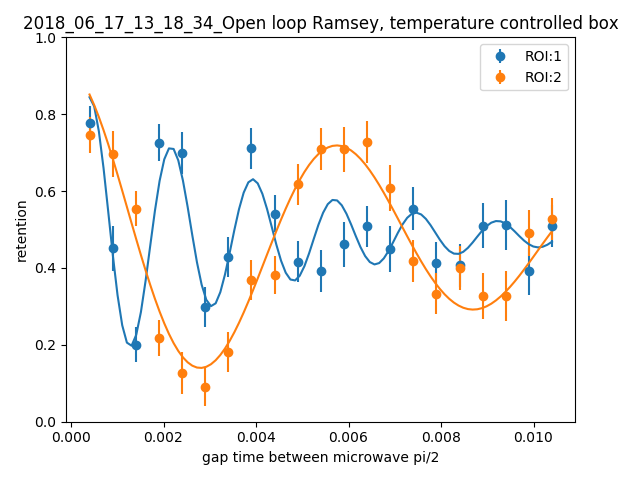

[0.017, 0.28267671849755699, 350, 1.5707963267948966, 0.49318535046796025]
tau 1  is  0.00393573589811  with 1 std of   0.00108180162586
amplitude 1  is  0.399464471872  with 1 std of   0.0728287082538
frequency 1  is  566.579264473  with 1 std of   12.6269786702
phase 1  is  0.0847179580327  with 1 std of   0.235570597525
offset 1  is  0.484072508018  with 1 std of   0.0158103452455
[0.017, 0.29025377296053978, 350, 1.5707963267948966, 0.4552007724940057]
tau 2  is  0.00969155447419  with 1 std of   0.0026499622545
amplitude 2  is  0.44676850202  with 1 std of   0.0574455247071
frequency 2  is  169.579791538  with 1 std of   4.29089495577
phase 2  is  1.63479061821  with 1 std of   0.125867955287
offset 2  is  0.473031928599  with 1 std of   0.0151836354849
2018_06_17_14_02_42_Open loop Ramsey, temperature controlled box
2


<IPython.core.display.Javascript object>


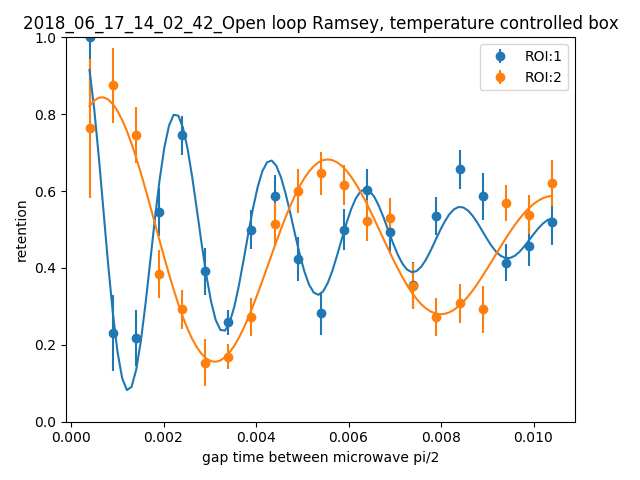

[0.017, 0.50958378091638412, 350, 1.5707963267948966, 0.49041621908361593]
tau 1  is  0.00426368531707  with 1 std of   0.000738397315712
amplitude 1  is  0.540514664351  with 1 std of   0.0636519663354
frequency 1  is  487.52986623  with 1 std of   7.09728885607
phase 1  is  0.850349159773  with 1 std of   0.136338643729
offset 1  is  0.484137810858  with 1 std of   0.0135097535495
[0.017, 0.3967920967920967, 350, 1.5707963267948966, 0.4782079032079033]
tau 2  is  0.00911219691278  with 1 std of   0.00200774767976
amplitude 2  is  -0.421235539462  with 1 std of   0.0437184004382
frequency 2  is  204.677488485  with 1 std of   4.81618747605
phase 2  is  3.77097072219  with 1 std of   0.139776818329
offset 2  is  0.454199308117  with 1 std of   0.0134531035656
2018_06_17_14_46_09_Open loop Ramsey, temperature controlled box
3


<IPython.core.display.Javascript object>


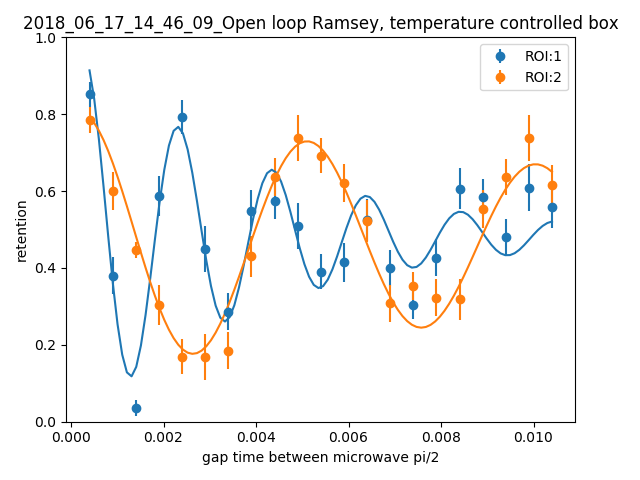

[0.017, 0.36067923546620523, 350, 1.5707963267948966, 0.49117261638564663]
tau 1  is  0.00408941384591  with 1 std of   0.0009322545991
amplitude 1  is  0.502033324969  with 1 std of   0.0769570558982
frequency 1  is  490.93650681  with 1 std of   10.1109475514
phase 1  is  0.661780529091  with 1 std of   0.191075993225
offset 1  is  0.482581032958  with 1 std of   0.0166834877973
[0.017, 0.30147630147630144, 350, 1.5707963267948966, 0.48313908313908316]
tau 2  is  0.0187958967664  with 1 std of   0.00801798398161
amplitude 2  is  0.339287520795  with 1 std of   0.0422509966865
frequency 2  is  202.452886732  with 1 std of   4.41118674683
phase 2  is  1.31966372314  with 1 std of   0.143874023057
offset 2  is  0.471247601853  with 1 std of   0.013824734646
2018_06_17_15_41_15_Open loop Ramsey, temperature controlled box
4


<IPython.core.display.Javascript object>


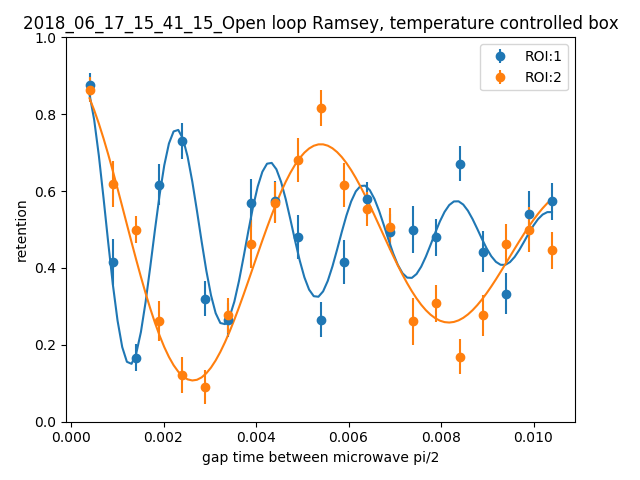

[0.017, 0.3841639494686262, 350, 1.5707963267948966, 0.4908360505313738]
tau 1  is  0.00543696098501  with 1 std of   0.0013004981127
amplitude 1  is  0.423468307943  with 1 std of   0.0631640176994
frequency 1  is  495.864523639  with 1 std of   7.91271150067
phase 1  is  0.682847437237  with 1 std of   0.178132636937
offset 1  is  0.483070586069  with 1 std of   0.0152073909778
[0.017, 0.41792978263566499, 350, 1.5707963267948966, 0.44570658100069865]
tau 2  is  0.00983700074115  with 1 std of   0.00272256056888
amplitude 2  is  0.459698356178  with 1 std of   0.059894035239
frequency 2  is  180.682576646  with 1 std of   4.4537573562
phase 2  is  1.63258362532  with 1 std of   0.129438372871
offset 2  is  0.457585001005  with 1 std of   0.0162402703635
2018_06_17_16_22_40_Open loop Ramsey, temperature controlled box
5


<IPython.core.display.Javascript object>


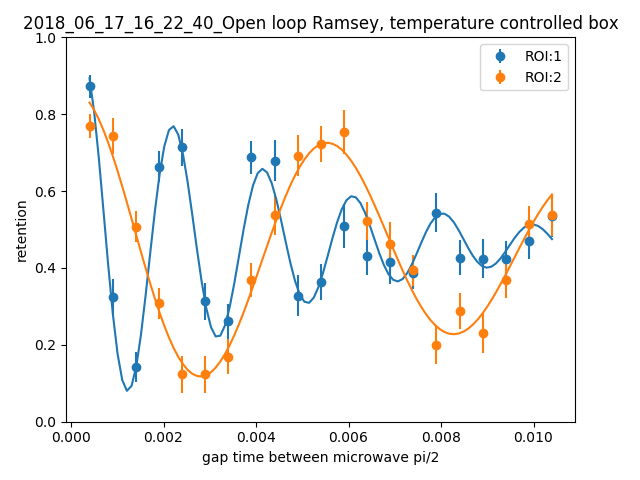

[0.017, 0.40008967071014373, 350, 1.5707963267948966, 0.47200335254567022]
tau 1  is  0.00428994312369  with 1 std of   0.000681149010196
amplitude 1  is  0.512101600062  with 1 std of   0.0538165109401
frequency 1  is  514.5633137  with 1 std of   6.40938951745
phase 1  is  0.674946129622  with 1 std of   0.126085895784
offset 1  is  0.463468815514  with 1 std of   0.0116668393166
[0.017, 0.32449772449772452, 350, 1.5707963267948966, 0.44473304473304476]
tau 2  is  0.0137067868272  with 1 std of   0.0034561152397
amplitude 2  is  -0.410802295121  with 1 std of   0.0371383590514
frequency 2  is  182.782837469  with 1 std of   3.02810000862
phase 2  is  4.57451590176  with 1 std of   0.0980268786917
offset 2  is  0.451880599099  with 1 std of   0.0113954267413


In [11]:
save_figures=False
data11 = []
for n in range(0,len(assorted['exp_ids'])):    
    print assorted['exp_ids'][n]
    assorted_roi3freqs=[]
    assorted_roi2freqs=[]
    assorted_roi3perr=[]
    assorted_roi2perr=[]
    i = n
    print i
    exp_id=assorted['exp_ids'][i]
    q=assorted['qdp_class'][i]
    q.experiments[0]['variable_list']
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    q.get_thresholds()
    retention = q.apply_thresholds()


    colors=[ '#ff7f0e','#1f77b4','#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fig, ax = plt.subplots()
    fit_guesses=[0.006, 0.43, 409 ,1.107, 0.47]
    fit_guesses2=[  0.522, 0.411, 190 ,1.52, 0.5]
    #roi_dependency=[0,0,0,0,0]
    fitted_parameters=[]
    freqarray = []
    for roi in [1,2]:
        error=0
        data = []
        reten = []
        err = []

        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        offsetguess = np.mean(reten)
        Ampguess = np.max(reten)-offsetguess
        fit_guesses = [0.017,Ampguess , 350 ,np.pi/2, offsetguess]   
        print fit_guesses
        ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
        #guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
        #try:
       # decaying_sin(t,tau,amp,freq,phase,offset)
        try:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offset',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

        except:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offsett',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

           #fit2,pcov2 = curve_fit(gaussian,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
       # except RuntimeError:
       #     error=1
    #     if error is not 1:
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit[0],fit[1],fit[2])
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit2[0],fit2[1],fit2[2])

        xarray=np.linspace(np.min(data),np.max(data),100)
        yfit=decaying_sin(xarray, fit[0], fit[1], fit[2], fit[3],fit[4])
       # yfit2=decaying_sin(xarray, 0.522, 0.411, 190 ,1.52, 0.5)
        plt.plot(xarray,yfit,color=colors[roi])
       # plt.plot(xarray,yfit2,color=colors[roi])
           # yfit2=gaussian(xarray, fit2[0], fit2[1], fit2[2], fit2[3])
            #plt.plot(xarray,yfit,label="mj=5/2", color=colors[0])
            #plt.plot(xarray,yfit2,label="mj=3/2", color=colors[1])

    #         if roi==3:
    #             assorted_roi3freqs.append(fit[2])
    #             assorted_roi3perr.append(np.sqrt(pcov[2][2]))
    #         elif roi==2:
    #             assorted_roi2freqs.append(fit[2])
    #             assorted_roi2perr.append(np.sqrt(pcov[2][2]))

    ax.set_title(exp_id)
    ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('retention')
    ax.legend()
    plt.tight_layout()
    plt.show()
    if save_figures:
        plt.savefig('{}.pdf'.format(exp_id))
    
    
    
    starting_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][0])).strftime('%Y-%m-%d %H:%M:%S')
    end_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][len(assorted['timestamps'][i])-1])).strftime('%Y-%m-%d %H:%M:%S')
    middle_time = dt.datetime.fromtimestamp(int((assorted['timestamps'][i][0]+assorted['timestamps'][i][len(assorted['timestamps'][i])-1])/2 )).strftime('%H:%M')
    time_length = (assorted['timestamps'][i][len(assorted['timestamps'][i])-1])-assorted['timestamps'][i][0]
    time_from_data_start = ((assorted['timestamps'][i][0]+assorted['timestamps'][i][len(assorted['timestamps'][i])-1])/2 ) - assorted['timestamps'][0][0] 
    data11.append([ starting_time,end_time,freqarray[0],freqarray[1],freqarray[2],freqarray[3],middle_time,time_length,time_from_data_start])



<IPython.core.display.Javascript object>


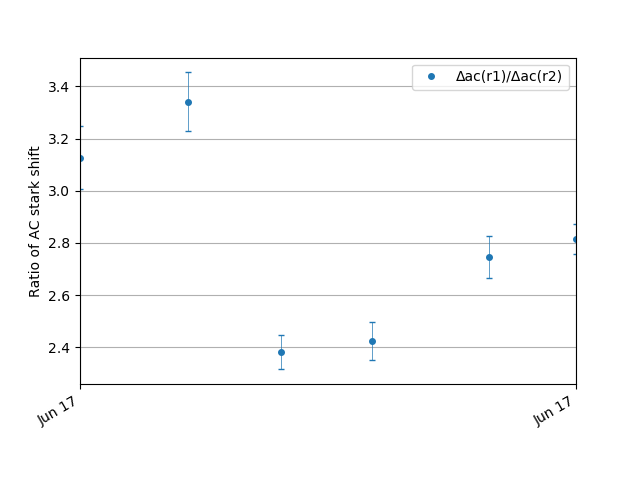

<IPython.core.display.Javascript object>


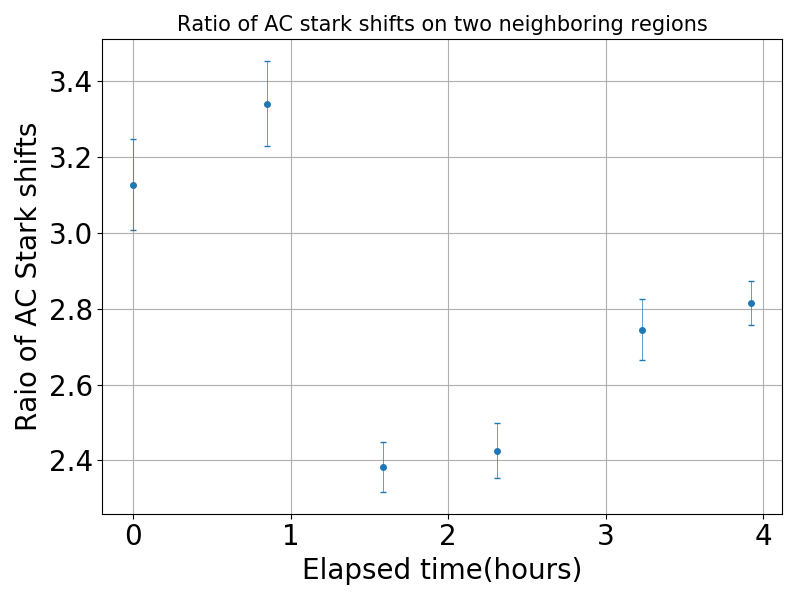

In [13]:
savefig=False
ratio_data=[]
ratio_error=[]
avetimestamp=[]
timelength=[]
startingtime=[]
startingtime_in_UNIX=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    startingtime_in_UNIX.append(assorted['timestamps'][i][0])
    ratio_data.append(data11[i][2]/data11[i][4])
    error_total=np.sqrt(((1/data11[i][4])*data11[i][3])**2+(((data11[i][2]/(data11[i][4])**2)*data11[i][5])**2))
    ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])

#samplerate='2S'
#df=pd.DataFrame({  "Δac(r1)/Δac(r2)": ratio_data,'timestamps': avetimestamp,'error': ratio_error,'off_data': off_data},index=startingtime)
df=pd.DataFrame({  "Δac(r1)/Δac(r2)": ratio_data,'timestamps': avetimestamp,'error': ratio_error},index=startingtime)

ax=df.plot(y=[ "Δac(r1)/Δac(r2)"],yerr='error',capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',color=['#1f77b4', '#d62728'])
days=md.DayLocator()
hours=md.HourLocator()
#ax.set_xlim(dt.datetime(2018,5,22))
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('Ratio of AC stark shift')
ax.grid()
#plt.savefig('Alignment_20180415.png')

timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
#ax.set_ylim(-0.3,0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='AC Stark shift ratios'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


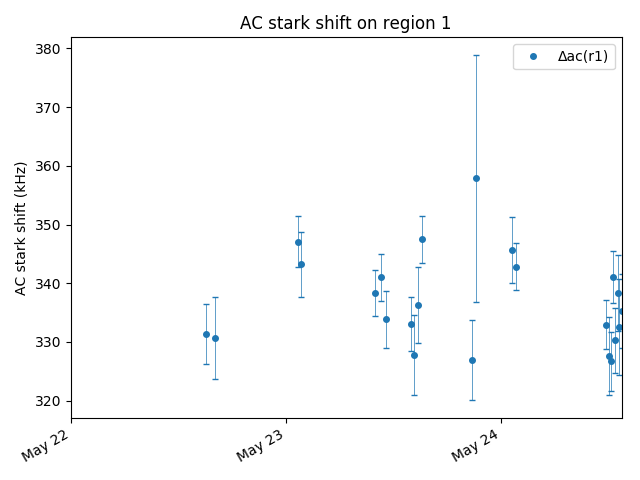

<IPython.core.display.Javascript object>


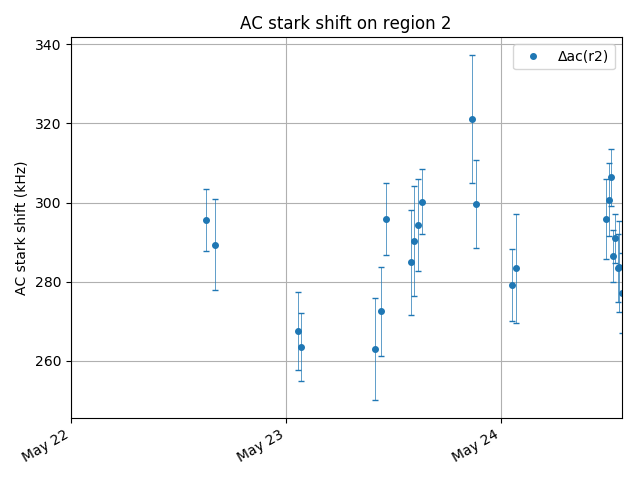

In [39]:

ROI1_ac=[]
ROI1_err=[]
ROI2_ac=[]
ROI2_err=[]
avetimestamp=[]
timelength=[]
startingtime=[]
ROI_err=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    ROI1_ac.append(data11[i][2])
    ROI_err.append([data11[i][3],data11[i][5]])
   # ROI_err.append(data11[i][3])
   # ROI_err.append(data11[i][5])
    ROI1_err.append(data11[i][3])
    ROI2_ac.append(data11[i][4])
    ROI2_err.append(data11[i][5])
    #ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])
 
# Using Pandas

df2=pd.DataFrame({  "Δac(r1)": ROI1_ac,'Δac(r2)':ROI2_ac,'timestamps': avetimestamp,'ROI_err': ROI_err},index=startingtime)

ax=df2.plot(y=[ "Δac(r1)"],yerr=ROI1_err,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
hours=md.HourLocator()
ax.set_xlim(dt.datetime(2018,5,22))
ax.xaxis.set_major_locator(days)
#ax.xaxis.set_minor_locator(hours)
ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('AC stark shift (kHz)')
ax.grid()
ax.set_title('AC stark shift on region 1')
plt.tight_layout()
if savefig:
    plt.savefig('r1_ac_starkshift.pdf')

ax2=df2.plot(y=[ "Δac(r2)"],yerr=ROI2_err,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
hours=md.HourLocator()
ax2.set_xlim(dt.datetime(2018,5,22))
ax2.xaxis.set_major_locator(days)
ax2.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax2.set_ylabel('AC stark shift')
ax2.grid()
ax2.set_ylabel('AC stark shift (kHz)')
ax2.set_title('AC stark shift on region 2')
plt.tight_layout()
if savefig:
    plt.savefig('r2_ac_starkshift.pdf')


In [40]:
ax.set_ylabel('AC stark shift (kHz)')
ax.grid()
ax.set_title('AC stark shift on region 1')
plt.tight_layout()
plt.savefig('r1_ac_starkshift')
# peakshift_r1 = 825.0
# peakshift_r2 = 825.0
# wx_r1 = 8.2
# wx_r2= 8.2
peakshift=825
wx=8.1
spacing = 9.25
xx = np.arange(-10.0, 10.0, 0.1)
# fig, ax = plt.subplots()
# plt.plot(xx,gaussian(xx,peakshift,-spacing/2,wx,0))
# plt.plot(xx,gaussian(xx,peakshift,spacing/2,wx,0))
# plt.show()

# fig, ax = plt.subplots()
# xxx = np.arange(-.3, 0.3, 0.005)
# plt.plot(xxx,(gaussian(xxx,peakshift,spacing/2,wx,0)/gaussian(xxx,peakshift,-spacing/2,wx,0)))
# plt.show()


In [41]:
def gaussian2(x,amp,x0,sigma,offset):
    res=(amp*sp.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res
#print gaussian(4,peakshift,spacing/2,wx,0)
#x=Symbol('x')
#print gaussian(y,peakshift,spacing/2,wx,0)
#print solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-1.1,x)


ratio_data=[]
ratio_error=[]
avetimestamp=[]
timelength=[]
startingtime=[]
avetimestamp=[]

for i in range(0,len(assorted['exp_ids'])):
#for i in [1]:
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    ratio_data.append(data11[i][2]/data11[i][4])
    error_total=np.sqrt(((1/data11[i][4])*data11[i][3])**2+(((data11[i][2]/(data11[i][4])**2)*data11[i][5])**2))
    ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])
#print error_total
ratio_to_dist=[]  
x=Symbol('x')
dist_max_error=[]
dist_min_error=[]
error_all=[]
for z in range(0,len(ratio_error)):
    print "doing {}-th fit.. out of {}".format(z,len(ratio_error))
    center_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z],x)
    max_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]-ratio_error[z],x)
    min_val =  solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]+ratio_error[z],x)
    ratio_to_dist.append(np.float(center_val[0]))
    maxerr = max_val[0] - center_val[0]
    minerr = center_val[0]- min_val[0]
    dist_max_error.append(np.float(maxerr))
    dist_min_error.append(np.float(minerr))
    error_all.append([np.float(maxerr),np.float(minerr)])

doing 0-th fit.. out of 23
doing 1-th fit.. out of 23
doing 2-th fit.. out of 23
doing 3-th fit.. out of 23
doing 4-th fit.. out of 23
doing 5-th fit.. out of 23
doing 6-th fit.. out of 23
doing 7-th fit.. out of 23
doing 8-th fit.. out of 23
doing 9-th fit.. out of 23
doing 10-th fit.. out of 23
doing 11-th fit.. out of 23
doing 12-th fit.. out of 23
doing 13-th fit.. out of 23
doing 14-th fit.. out of 23
doing 15-th fit.. out of 23
doing 16-th fit.. out of 23
doing 17-th fit.. out of 23
doing 18-th fit.. out of 23
doing 19-th fit.. out of 23
doing 20-th fit.. out of 23
doing 21-th fit.. out of 23
doing 22-th fit.. out of 23


<IPython.core.display.Javascript object>


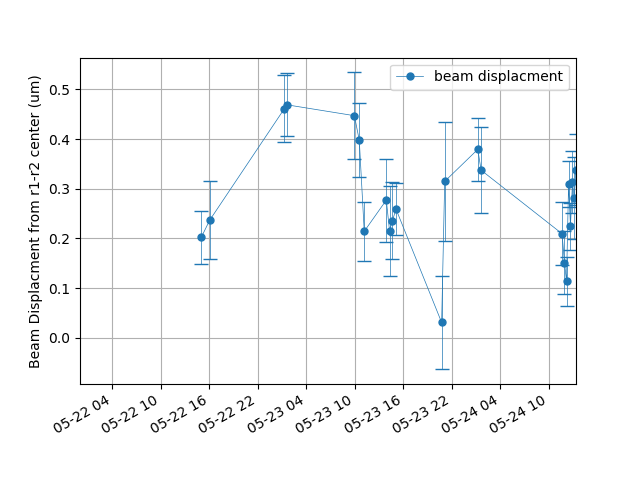

In [54]:
df4=pd.DataFrame({ "beam displacment": ratio_to_dist,'Max_error': dist_max_error,'Min_error': dist_min_error},index=startingtime)
ax=df4.plot(y=["beam displacment"],yerr=[dist_max_error,dist_min_error],capsize=5,lw=0.5,marker='o',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from r1-r2 center (um)')
ax.set_xlim(dt.datetime(2018,5,22))
ax.grid()

<IPython.core.display.Javascript object>


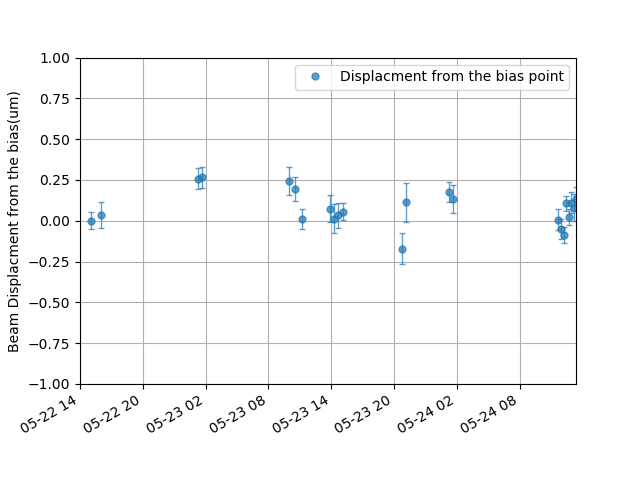

In [55]:
start_offset=np.mean(ratio_to_dist[0]) # Off
displacement_frombias=ratio_to_dist-start_offset
df5=pd.DataFrame({"Displacment from the bias point":displacement_frombias ,'Max_error': dist_max_error,'Min_error': dist_min_error},index=startingtime)
ax=df5.plot(y=["Displacment from the bias point"],yerr=[dist_max_error,dist_min_error],capsize=2,lw=1,marker='o',alpha=0.7,linestyle='None',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from the bias(um)')
ax.set_xlim(dt.datetime(2018,5,22,14))
ax.set_ylim(-1,1)
#days=md.DayLocator()
#ax.xaxis.set_major_locator(days)
#ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))

ax.grid()

<IPython.core.display.Javascript object>


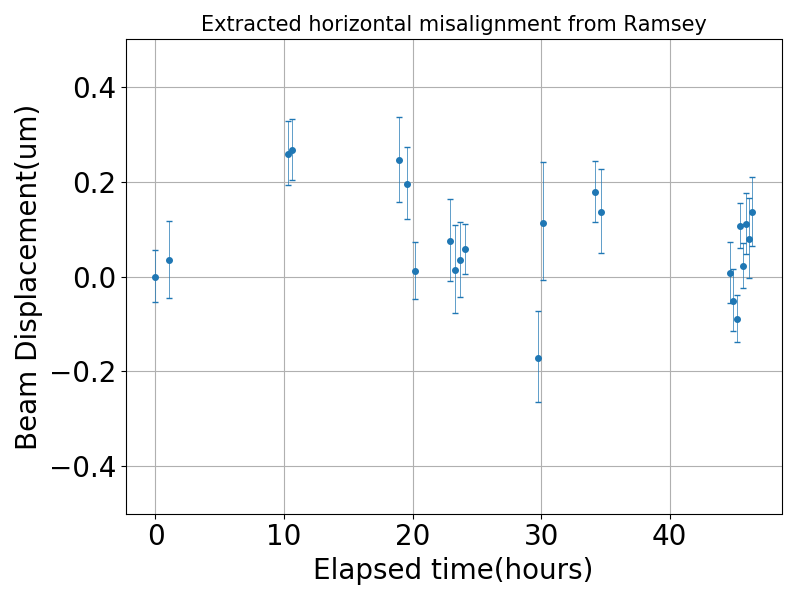

In [56]:
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Beam Displacement(um)',fontsize=20)
ax.set_title('Extracted horizontal misalignment from Ramsey',fontsize=15)
ax.set_ylim(-0.5,0.5)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Extracted_horizontal_misalignment_from_Ramsey'
# plt.savefig(filename+'.png')
# plt.savefig(filename+'.pdf')
# plt.savefig(filename+'.eps')

# TIME SERIES ANALYSES

In [43]:
keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
         'AAS_redside',
         'AAS_blueside',
 'timestamp_measurements',
 'timestamp_iteration']

actuator_variables=['Red_X','Red_Y']

# exp_ids : This is list for Ramsey experiments.
# There are more experients with AAS on. Add them in this list
AAS_ids=[
        ]

entire_closed_ids=exp_ids+AAS_ids


data={}
for j in range(0,len(entire_closed_ids)):
    exp_id=entire_closed_ids[j]
    q=open_data(exp_id)
    e=0
    for i in q.experiments[e]['iterations']:
        for key in keylist:
            if i==0 and j==0:
                data[key]=[]
            try:
                data[key].append(q.experiments[e]['iterations'][i][key])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)

        for var in actuator_variables:
            if i==0 and j==0:
                data[var]=[]
            try:
                data[var].append(q.experiments[e]['iterations'][i]['variables'][var])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, var)
                

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_15/2018_06_15_15_14_12_Ramsey between sites/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_15/2018_06_15_16_32_36_Ramsey between sites/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_15/2018_06_15_17_12_13_Ramsey between sites/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_15/2018_06_15_17_54_00_Ramsey between sites/qdp.txt


In [12]:
dates

True

<IPython.core.display.Javascript object>


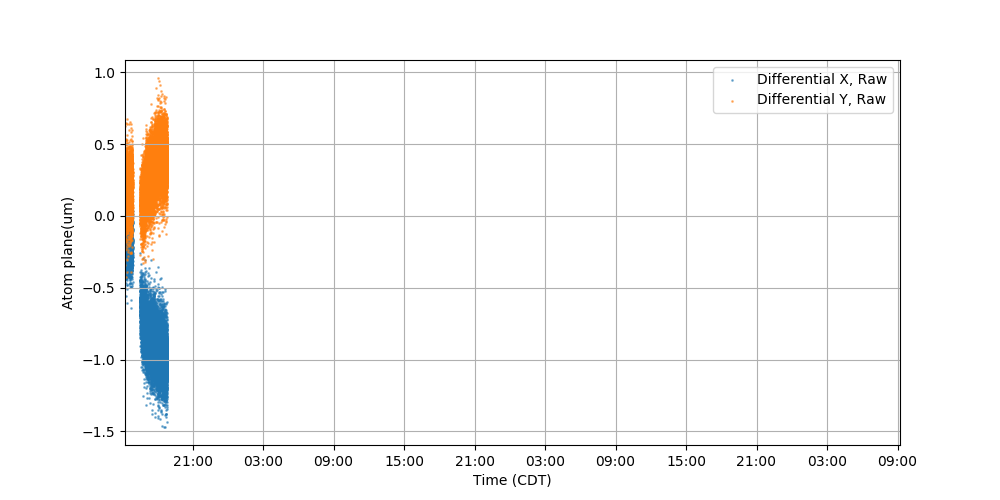

In [48]:
savefig=False
data_cutoff=0
xfmt=md.DateFormatter('%H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

ax.xaxis.set_major_formatter(xfmt)
data_to_plot=flatteneddata0-flatteneddata2-(flatteneddata0[0]-flatteneddata2[0])
ax.scatter(dates,data_to_plot,s=1,alpha=0.5,label='Differential X, Raw')
ax.set_xlim(dates[0],)
#ax.set_ylim(-1,1)

data_to_plot2=flatteneddata1-flatteneddata3-(flatteneddata1[0]-flatteneddata3[0])
ax.scatter(dates,data_to_plot2,s=1,alpha=0.5,label='Differential Y, Raw')
ax.grid()
ax.set_xlabel('Time (CDT)')
ax.set_ylabel('Atom plane(um)')
ax.legend()
if savefig:   
    plt.savefig('Alignment_over_night.png')

In [45]:
flattendedtimestamps[0]

1527019230.6429999

<IPython.core.display.Javascript object>


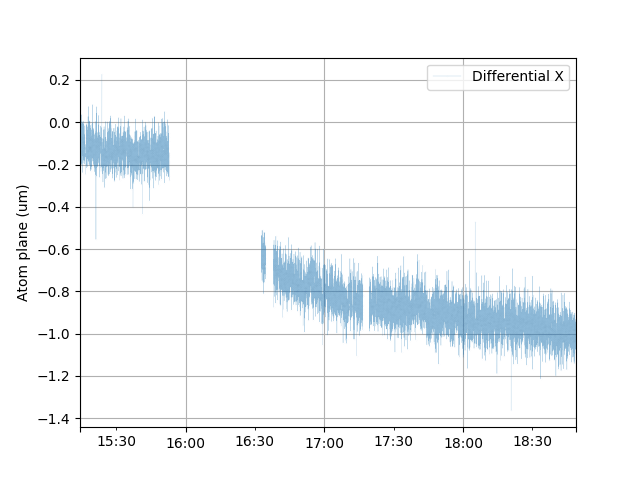

<IPython.core.display.Javascript object>


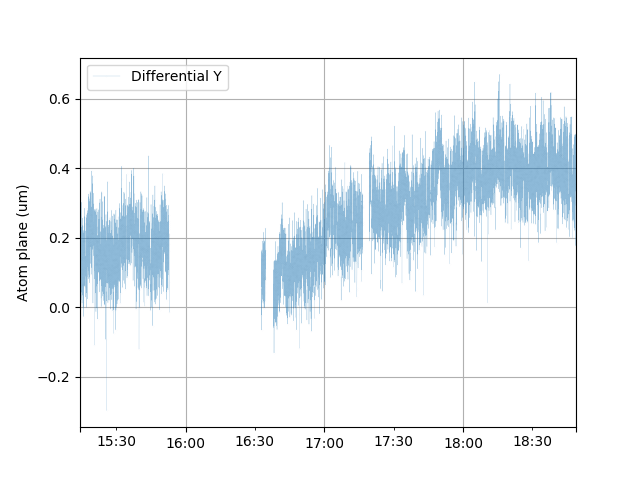

<IPython.core.display.Javascript object>


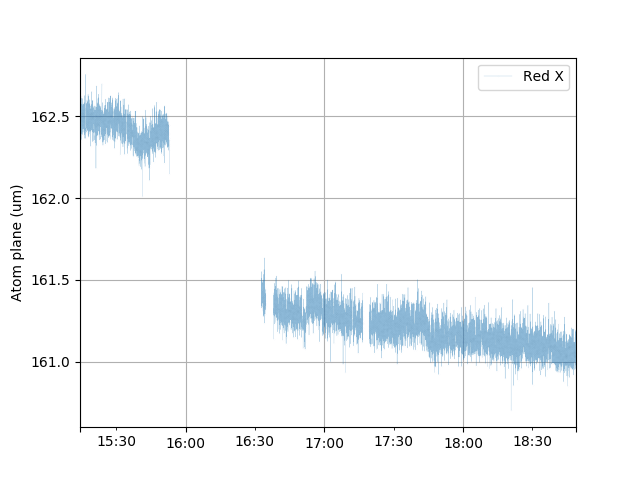

<IPython.core.display.Javascript object>


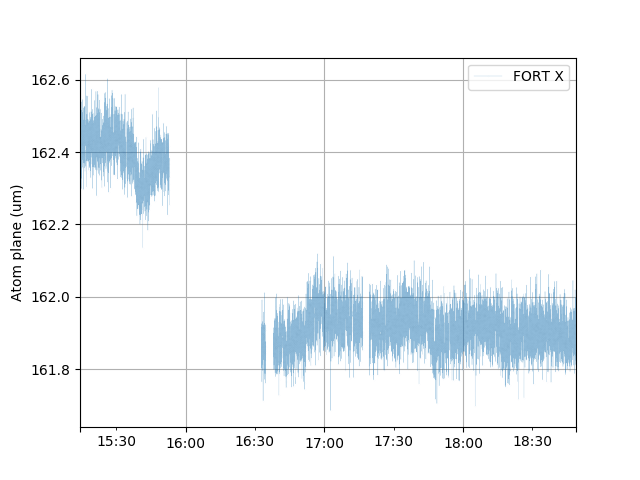

<IPython.core.display.Javascript object>


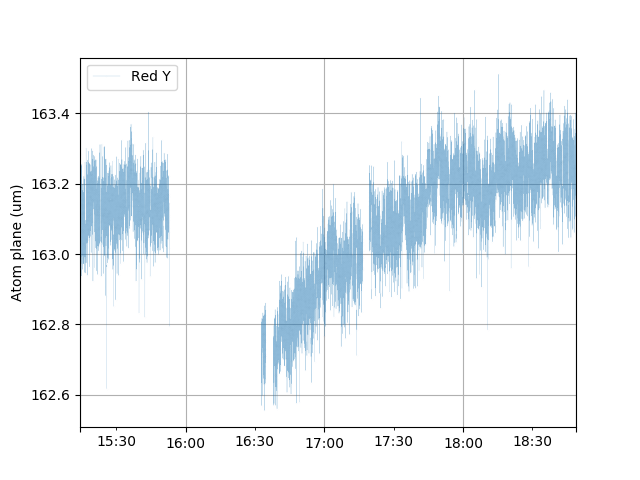

<IPython.core.display.Javascript object>


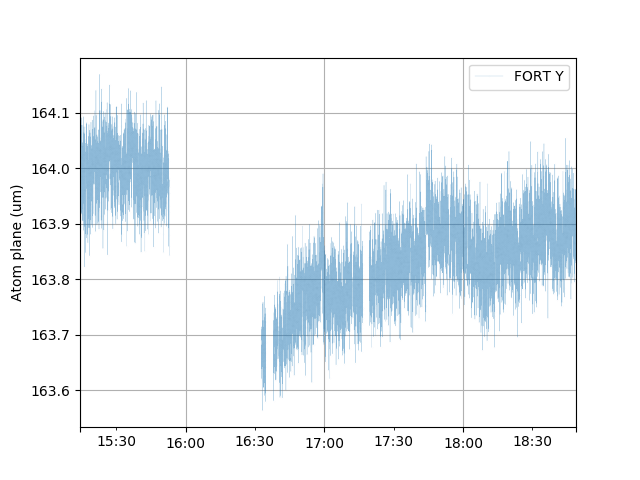

<IPython.core.display.Javascript object>


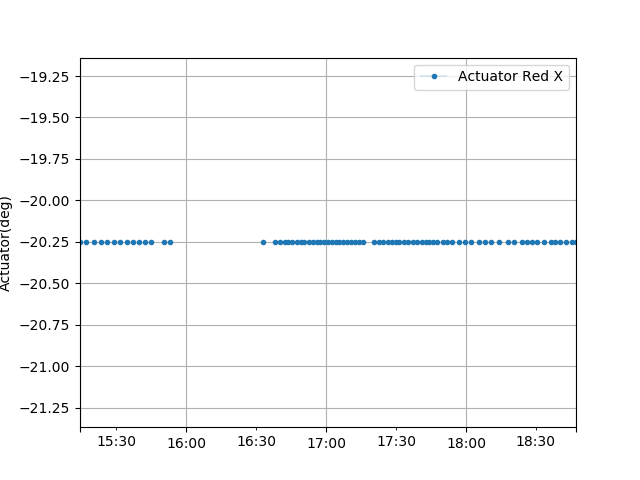

<IPython.core.display.Javascript object>


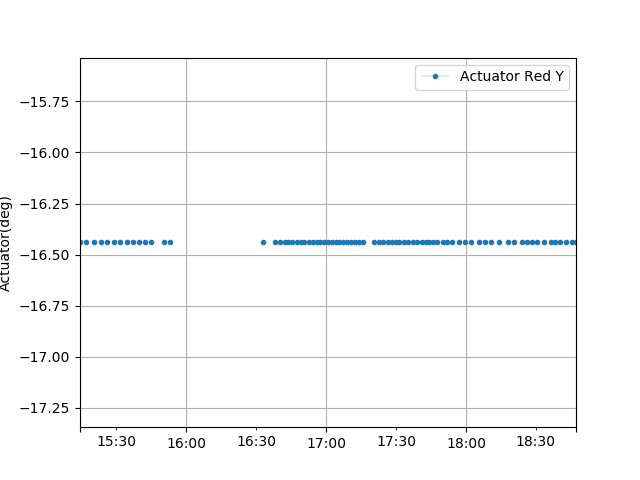

In [50]:
# Using Pandas
import pandas as pd
savefig=False
data_cutoff=0
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))

dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]
dates_iterations=[dt.datetime.fromtimestamp(ts) for ts in data['timestamp_iteration']]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

samplerate='1S'
offsetX=(flatteneddata0-flatteneddata2)[0]
offsetY=(flatteneddata1-flatteneddata3)[0]
df=pd.DataFrame({'Differential X': flatteneddata0-flatteneddata2-offsetX,
                 'Differential Y': flatteneddata1-flatteneddata3-offsetY,
                 'Red X': flatteneddata0,
                 'Red Y': flatteneddata1,
                 'FORT X': flatteneddata2,
                 'FORT Y': flatteneddata3,
                },index=dates)

df_actuators=pd.DataFrame({
                 'Actuator Red X':np.array(data['Red_X']),
                 'Actuator Red Y':np.array(data['Red_Y'])
                },index=dates_iterations)


## 
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Differential X'],alpha=0.5,lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

ax=data_to_plot2.plot(y=['Differential Y'],alpha=0.5,lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

ax=data_to_plot2.plot(y=['Red X'],alpha=0.5,lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

ax=data_to_plot2.plot(y=['FORT X'],alpha=0.5,lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

ax=data_to_plot2.plot(y=['Red Y'],alpha=0.5,lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

ax=data_to_plot2.plot(y=['FORT Y'],alpha=0.5,lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

data_to_plot3=df_actuators.resample(samplerate).mean()

ax=data_to_plot3.plot(y=['Actuator Red X'],alpha=1,lw=0.2,marker='.')
ax.set_ylabel('Actuator(deg)')
ax.grid()
ax.legend()

ax=data_to_plot3.plot(y=['Actuator Red Y'],alpha=1,lw=0.2,marker='.')
ax.set_ylabel('Actuator(deg)')
ax.grid()
ax.legend()



<IPython.core.display.Javascript object>


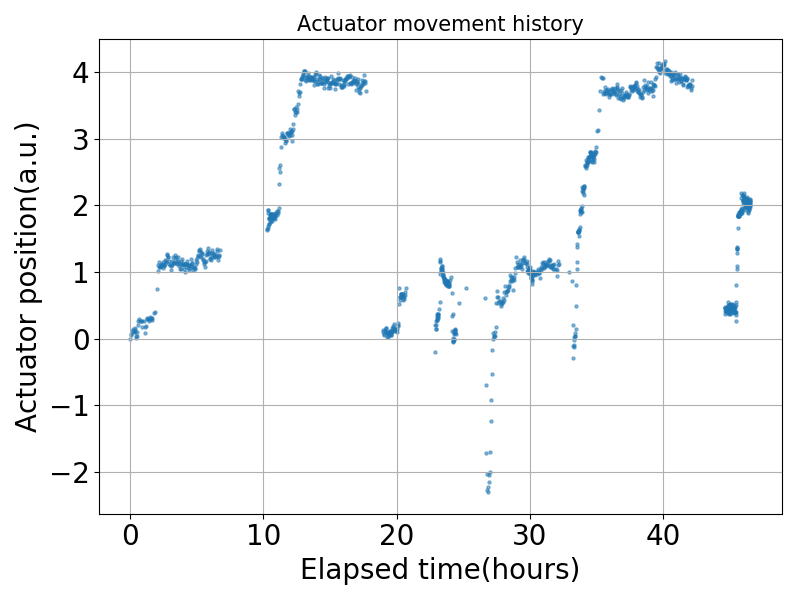

75
253
945
948


<IPython.core.display.Javascript object>


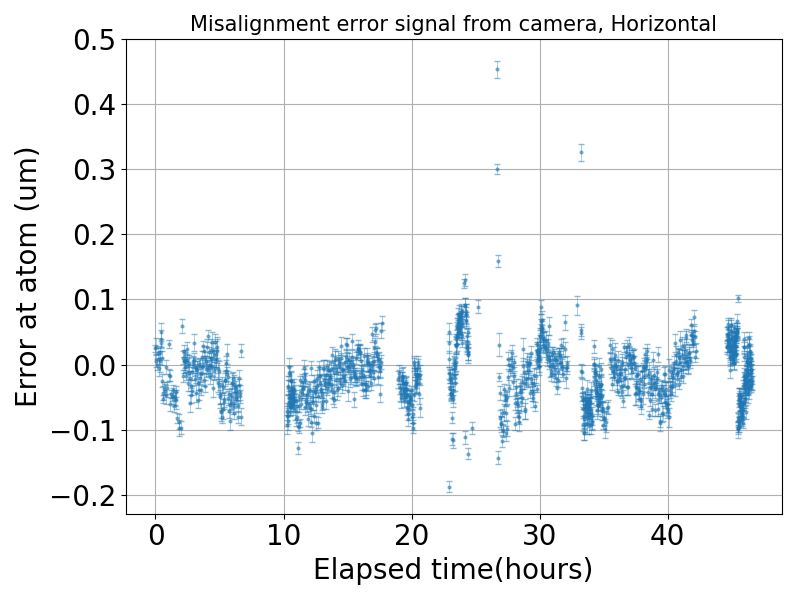

In [46]:
## Actuator Plot
savefig=True
actuator_x=np.array(data['Red_X'])
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(elapsed_time_in_hours,actuator_x-actuator_x[0],alpha=0.5,s=5)
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Actuator position(a.u.)',fontsize=20)
ax.set_title('Actuator movement history',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Actuator X History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

############ Camera error signal, X
camera_error_x=[]
camera_error_sigma_x=[]

samples=100
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        camera_error_x.append(data[keylist[4]][i]['error_x']/calibration_factor)
        camera_error_sigma_x.append(data[keylist[4]][i]['sigma_x']/math.sqrt(samples))
    except:
        print i
        camera_error_x.append(np.nan)
        camera_error_sigma_x.append(np.nan)
        
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=2,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Error at atom (um)',fontsize=20)
ax.set_title('Misalignment error signal from camera, Horizontal',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Camera AAS X History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


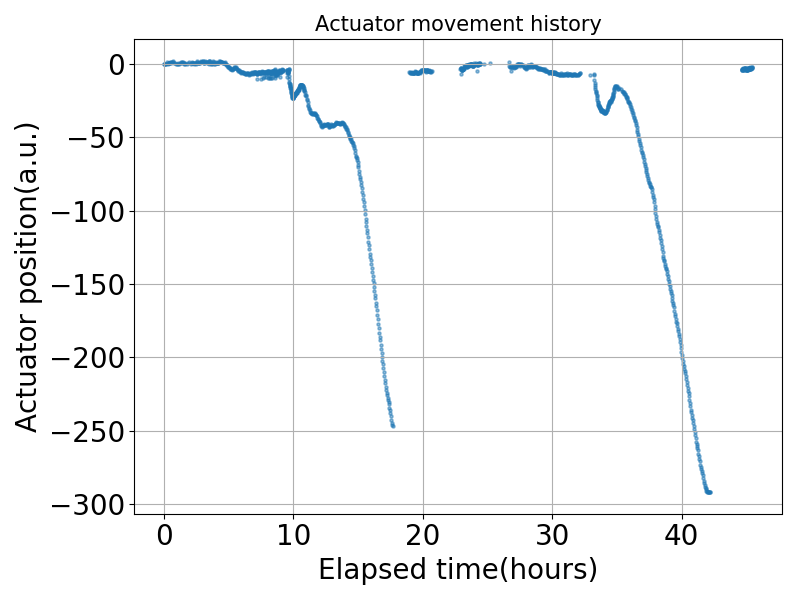

264
442
1029
1032


<IPython.core.display.Javascript object>


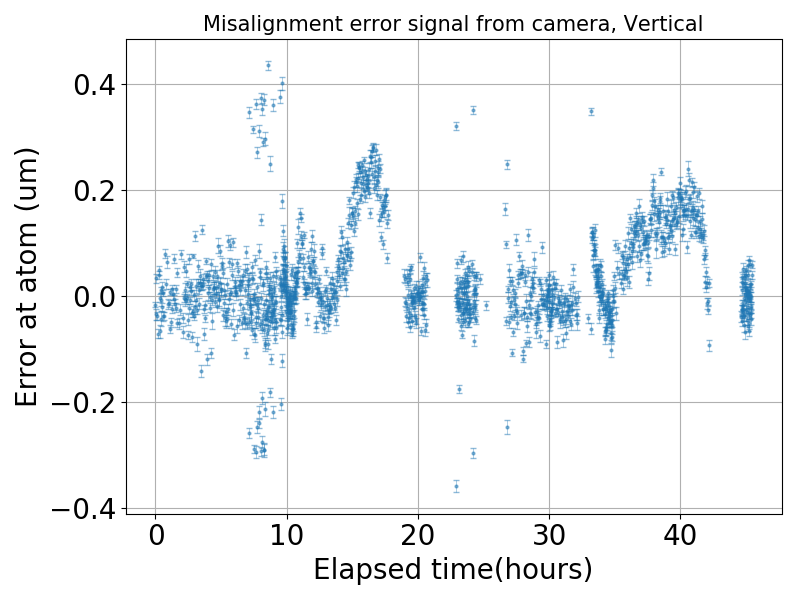

In [109]:
## Actuator Plot
savefig=True
actuator_y=np.array(data['Red_Y'])
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(elapsed_time_in_hours,actuator_y-actuator_y[0],alpha=0.5,s=5)
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Actuator position(a.u.)',fontsize=20)
ax.set_title('Actuator movement history',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Actuator Y History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

############ Camera error signal, Y
camera_error_y=[]
camera_error_sigma_y=[]

samples=100
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        camera_error_y.append(data[keylist[4]][i]['error_y']/calibration_factor)
        camera_error_sigma_y.append(data[keylist[4]][i]['sigma_y']/math.sqrt(samples))
    except:
        print i
        camera_error_y.append(np.nan)
        camera_error_sigma_y.append(np.nan)
        
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(elapsed_time_in_hours,camera_error_y,yerr=camera_error_sigma_y,capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=2,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Error at atom (um)',fontsize=20)
ax.set_title('Misalignment error signal from camera, Vertical',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Camera AAS Y History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

# Figuring out the dead region

<IPython.core.display.Javascript object>


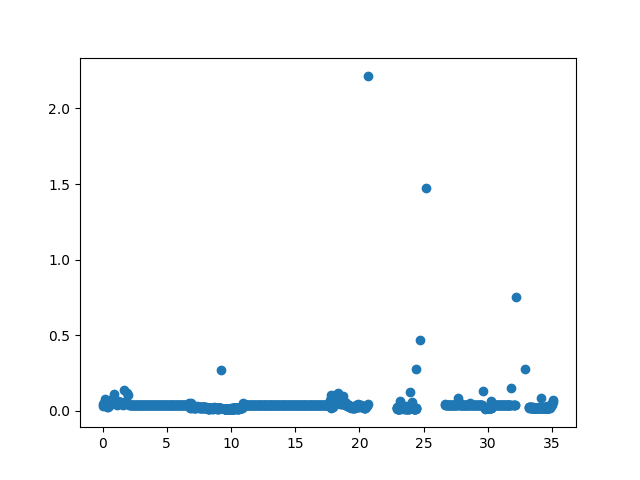

T=20.6829047222, duration of :2.21701666666


In [18]:
fig, ax= plt.subplots()
sorted_times=np.sort(elapsed_time_in_hours)
dead_times=sorted_times[1:]-sorted_times[0:-1]
ax.scatter(sorted_times[0:-1],dead_times)
threshold=2
dead_T=[]
dead_duration=[]
for i in range(0,len(dead_times)):
    if dead_times[i]>threshold:
        print 'T={}, duration of :{}'.format(sorted_times[0:-1][i],dead_times[i])
        dead_T.append(sorted_times[0:-1][i])
        dead_duration.append(dead_times[i])

<IPython.core.display.Javascript object>


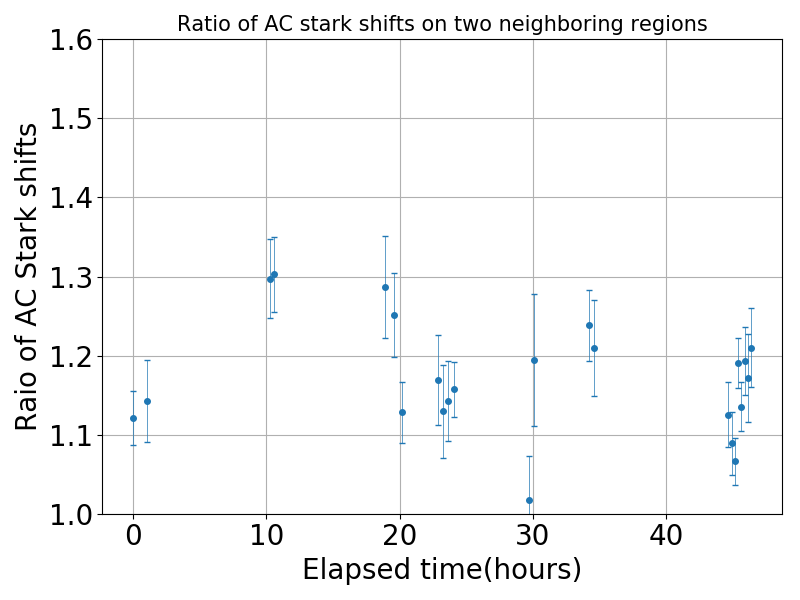

In [47]:
correction=0.7
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
# for i in range(0,len(dead_T)):
#     ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],1.1-0.3,1.1+0.3,alpha=0.1,color='r')
ax.set_ylim(1.3-0.3,1.3+0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()

# Insert room temperature history

<IPython.core.display.Javascript object>


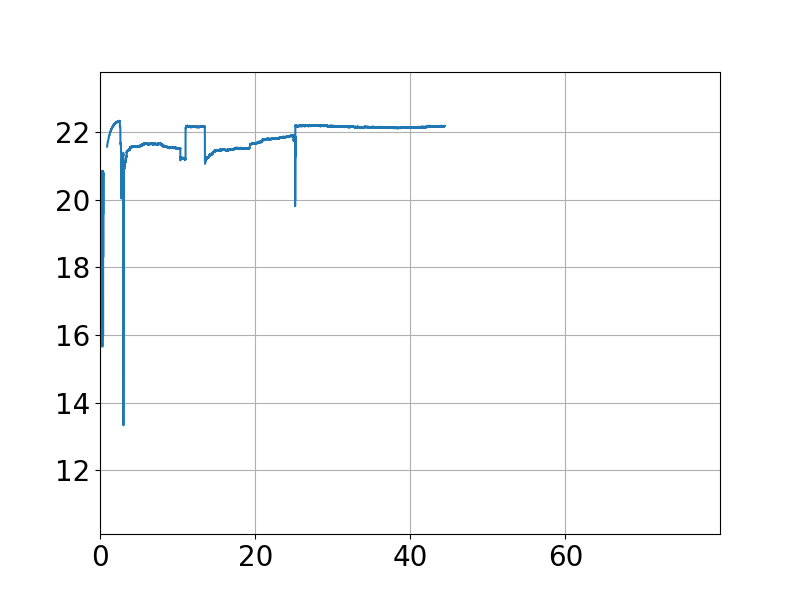

22.6327109524


In [56]:
from numpy import genfromtxt
my_data=genfromtxt('Rb_labtemperature.csv',delimiter=',')
temperatures_in_C=np.array(my_data[:,1])
timestamps=np.array(my_data[:,0])/2**32
offset=temperatures_in_C[0]#np.mean(temperatures_in_C)
experiment_start_time=flattendedtimestamps[0]


<IPython.core.display.Javascript object>


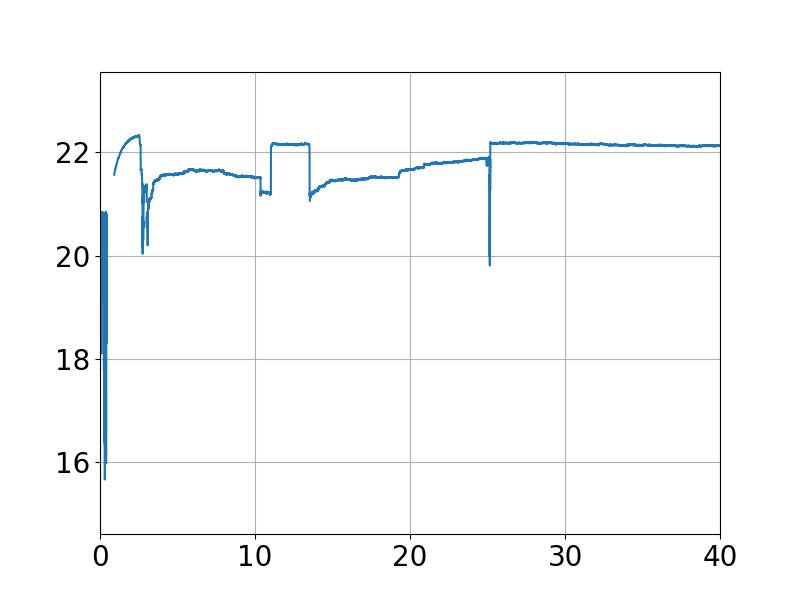

22.6327109524


In [60]:
# Cutting weird data off (due to bad eletric connection.. etc)
temp_threshold_upper=30
temp_threshold_lower=15

indices1 = temperatures_in_C > temp_threshold_upper
indices2 = temperatures_in_C < temp_threshold_lower
final_indices=np.logical_or(indices1,indices2)
temperatures_in_C[final_indices]=np.NaN
fig, ax=plt.subplots()
fig.set_size_inches(8,6)
ax.plot((timestamps-experiment_start_time)/3600,temperatures_in_C)
ax.grid()
ax.set_xlim(0,40)
ax.tick_params(labelsize=20)

# for i in range(0,len(dead_T)):
#      ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],-0.4,0.4,alpha=0.1,color='r')

print temperatures_in_C[0]

In [48]:
my_data

array([[  6.55712007e+18,   2.26327110e+01,   3.34742380e+03],
       [  6.55712008e+18,   2.26325596e+01,   3.34744660e+03],
       [  6.55712016e+18,   2.26359802e+01,   3.34693150e+03],
       ..., 
       [  6.55735520e+18,   2.24339886e+01,   3.37750250e+03],
       [  6.55735521e+18,   2.24349951e+01,   3.37734940e+03],
       [  6.55735522e+18,   2.24367175e+01,   3.37708740e+03]])

<IPython.core.display.Javascript object>


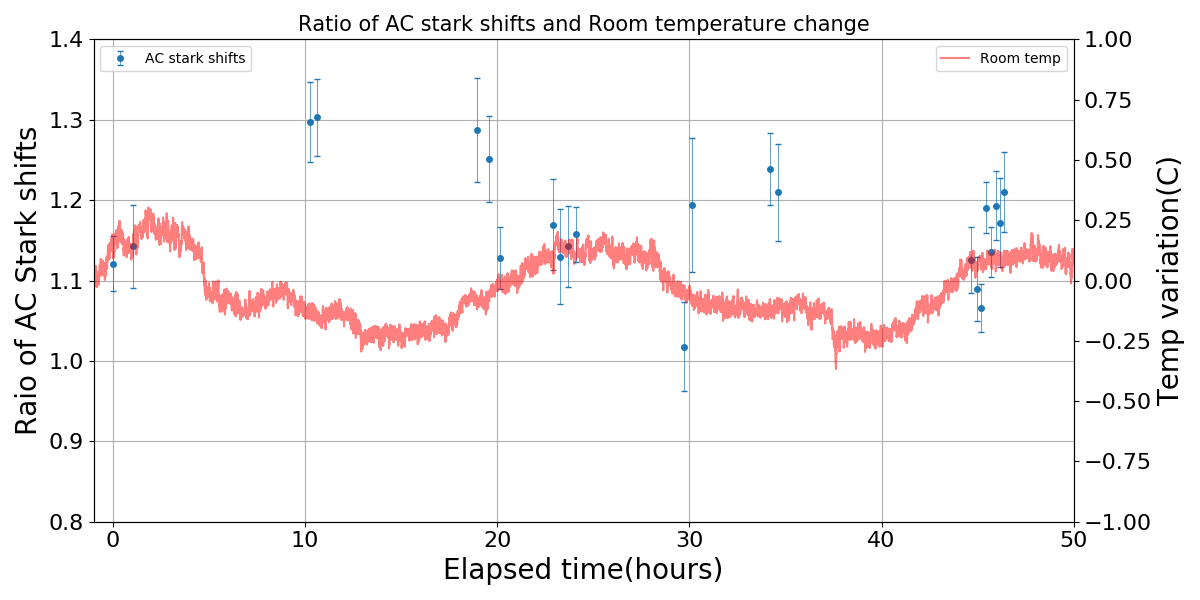

In [53]:
# Together!!
correction=0.7
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',label='AC stark shifts')
ax2=ax.twinx()
ax2.plot((timestamps-experiment_start_time)/3600,temperatures_in_C-offset,color='r',alpha=0.5,label='Room temp')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax2.set_ylabel('Temp variation(C)',fontsize=20)
ax.set_title('Ratio of AC stark shifts and Room temperature change',fontsize=15)
# for i in range(0,len(dead_T)):
#     ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],1.1-0.3,1.1+0.3,alpha=0.1,color='gray')

ax.set_xlim(-1,50)
ax.set_ylim(1.1-0.3,1.1+0.3)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylim(-1,1)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# filename='20180422_AC_starkshifts and temperature'
# plt.savefig(filename+'.png')
# plt.savefig(filename+'.pdf')
# plt.savefig(filename+'.eps')


<IPython.core.display.Javascript object>


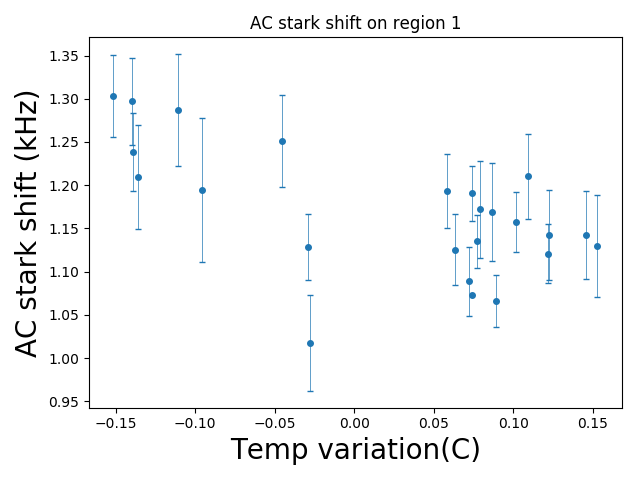

In [20]:
offset=22.85
interpolated_temperature=np.interp(timediff,(timestamps-experiment_start_time)/3600,temperatures_in_C-offset)
fig, ax=plt.subplots()
#ax.scatter(interpolated_temperature,ratio_data)
ax.errorbar(interpolated_temperature,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
#ax.set_aspect('equal')
ax.set_xlabel('Temp variation(C)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.grid()

<IPython.core.display.Javascript object>


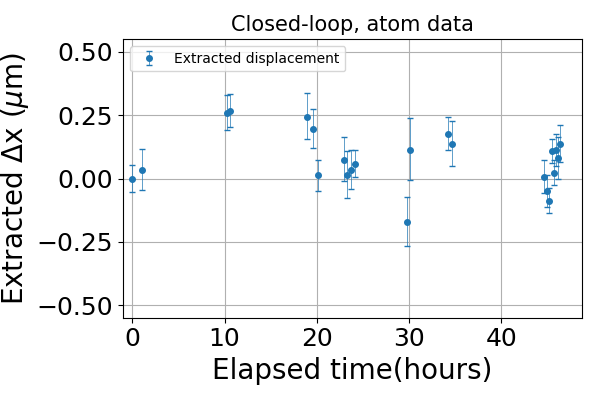

In [72]:
offset=22.85
display_ax2=False
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',label='Extracted displacement')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel(r'Extracted $\Delta$x ($\mu$m)',fontsize=20)
ax.tick_params(labelsize=18)
scaler=1
ax.set_ylim(scaler*-0.55,scaler*0.55)

if display_ax2:
    ax2=ax.twinx()
    ax2.plot((timestamps-experiment_start_time)/3600,temperatures_in_C-offset,color='r',alpha=0.3,label='System temperature')
    ax2.set_ylim(scaler*-0.3,scaler*0.3)
    ax2.tick_params(labelsize=16)
    ax2.set_ylabel(r'Temp variation $\Delta$T (C)',fontsize=20)
    ax2.legend(loc='upper right')
ax.grid()
ax.legend(loc='upper left')
ax.set_title('Closed-loop, atom data',fontsize=15)
plt.tight_layout()
ax.set_xlim(-1,)
filename='20180522_Extracted_horizontal_misalignment_and_Temperature'
savefig=True
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


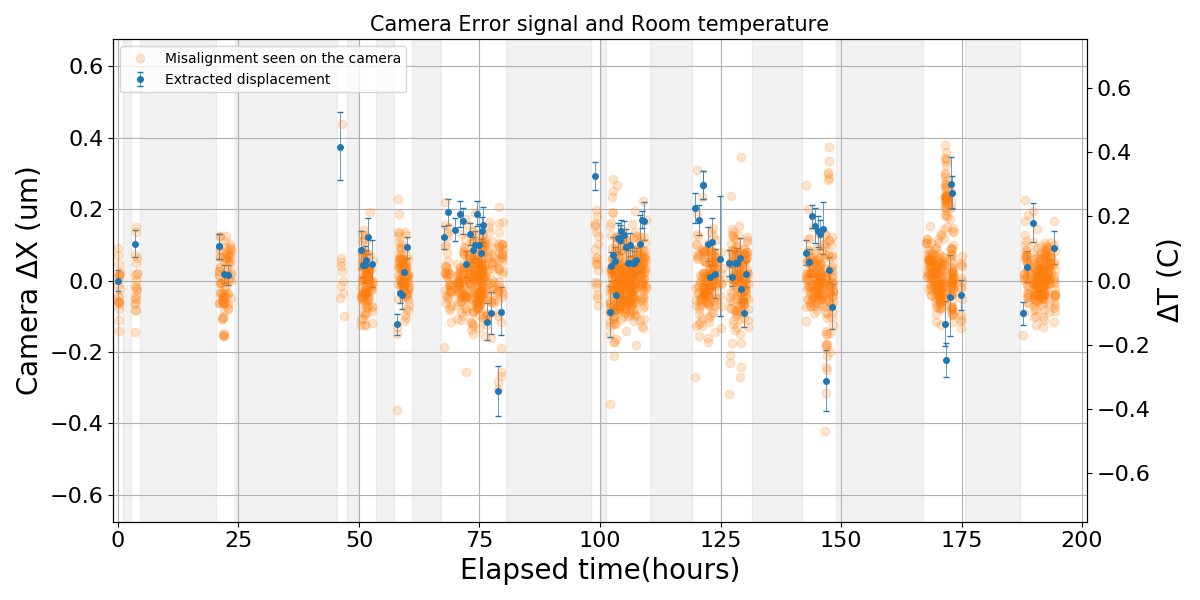

In [209]:
## Temperature and camera error signal plot
## Use pandas and resampling to plot them at similar time scale?
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',label='Extracted displacement')
ax.plot(elapsed_time_in_hours,camera_error_x,label='Misalignment seen on the camera',marker='o',linestyle='none',alpha=0.2)
ax2=ax.twinx()
#ax2.plot(timestamps,temperatures_in_C-offset,color='r',alpha=0.8,label='Room temp')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel(r'Camera $\Delta$X (um)',fontsize=20)
ax2.set_ylabel(r'$\Delta$T (C)',fontsize=20)
ax.set_title('Camera Error signal and Room temperature',fontsize=15)
scaler=1.5
for i in range(0,len(dead_T)):
    ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],scaler*-0.45,scaler*0.45,alpha=0.1,color='gray')

ax.set_ylim(scaler*-0.45,scaler*0.45)
ax2.set_ylim(scaler*-0.5,scaler*0.5)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
ax.set_xlim(-1,201)
filename='20180428_Camera_and_Atom_comparison'
savefig=True
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

In [ ]:
## Temperature and camera error signal plot
## Use pandas and resampling to plot them at similar time scale?
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
#ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.1,lw=0.5,marker='o',markersize=4,linestyle='None',label='Extracted displacement')
#ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.5,lw=0.5,markersize=4,linestyle='None',label='Extracted displacement')
ax.plot(elapsed_time_in_hours,camera_error_x,label='Extracted displacement',marker='o',linestyle='none',alpha=0.2)
#ax.hexbin(elapsed_time_in_hours,camera_error_x,gridsize=(300,10),label='Extracted displacement')
#ax.hexbin(elapsed_time_in_hours,camera_error_x,gridsize=(300,10),label='Extracted displacement')
ax2=ax.twinx()
ax2.plot(timestamps,temperatures_in_C-offset,color='r',alpha=0.8,label='Room temp')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel(r'Camera $\Delta$X (um)',fontsize=20)
ax2.set_ylabel(r'$\Delta$T (C)',fontsize=20)
ax.set_title('Camera Error signal and Room temperature',fontsize=15)
scaler=1.5
for i in range(0,len(dead_T)):
    ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],scaler*-0.45,scaler*0.45,alpha=0.1,color='gray')

ax.set_ylim(scaler*-0.45,scaler*0.45)
ax2.set_ylim(scaler*-0.5,scaler*0.5)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
ax.set_xlim(-1,201)
filename='20180428_camera_horizontal_misalignment_and_Temperature'
savefig=False
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


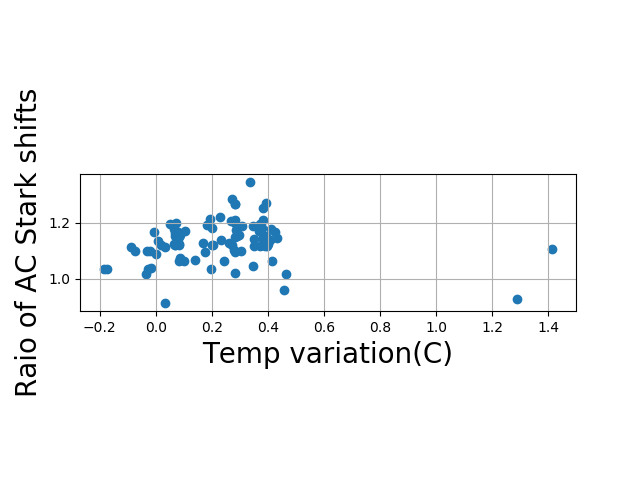

In [51]:
interpolated_temperature=np.interp(timediff,timestamps,temperatures_in_C-offset)
fig, ax=plt.subplots()
ax.scatter(interpolated_temperature,ratio_data)
ax.set_aspect('equal')
ax.set_xlabel('Temp variation(C)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.grid()

<IPython.core.display.Javascript object>


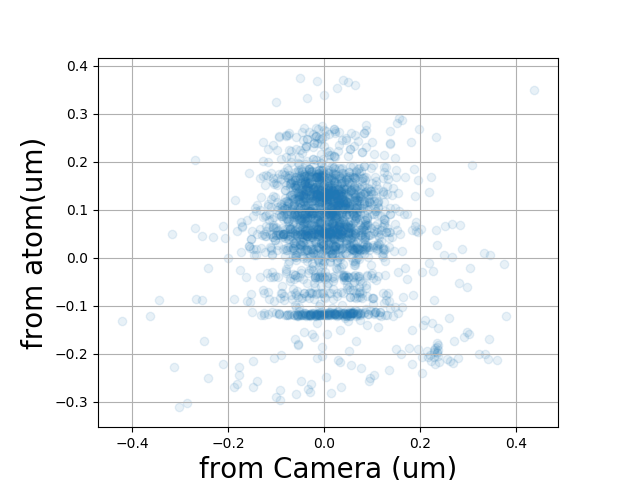

In [172]:
# Camera Error signal vs Atom signal
# elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x
time_offset=0
#interpolated_error_x=np.interp(timediff+time_offset,elapsed_time_in_hours,camera_error_x)
interpolated_atom_x=np.interp(elapsed_time_in_hours+time_offset,timediff,displacement_frombias)
fig, ax=plt.subplots()
#ax.hexbin(camera_error_x,interpolated_atom_x,gridsize=40)
#ax.scatter(camera_error_x,interpolated_atom_x,alpha=0.1)
ax.set_aspect('equal')
ax.set_xlabel('from Camera (um)',fontsize=20)
ax.set_ylabel('from atom(um)',fontsize=20)
ax.grid()
ax.set_aspect('equal')

In [154]:
np.size(elapsed_time_in_hours)

2195

In [126]:
timediff

array([   0.        ,    3.48471694,   20.94659722,   20.94659722,
         22.02374889,   22.83502472,   46.14175194,   50.43195417,
         50.84260028,   51.18150556,   51.51876861,   51.89722056,
         52.62958306,   57.91884361,   58.47059389,   58.96669083,
         59.43727583,   59.87217111,   67.66185556,   68.4693075 ,
         69.94930583,   70.91257583,   71.56578667,   72.24758389,
         72.94265833,   73.585415  ,   73.98553194,   74.47450361,
         74.86974083,   75.21645028,   75.52191667,   75.8017675 ,
         76.52271417,   77.30667389,   78.7948975 ,   79.47338528,
         98.91573222,  102.01844167,  102.33729306,  102.68075111,
        103.04679111,  103.39736528,  103.73350472,  104.14270861,
        104.44181667,  104.89870722,  105.32815   ,  105.78663028,
        106.17394333,  106.56550694,  106.95965389,  107.38826667,
        108.2555825 ,  108.67492139,  109.06880278,  119.80086333,
        120.55649056,  121.37411861,  121.37411861,  122.35684

# Allan deviation

In [51]:
from IPython.display import display, clear_output
name='20180615_openloop_boxtesting'
# Allan 
tau_list=range(1,100)+range(101,1001,10)+range(1002,10002,10)+range(10003,100003,10)#+range(80004,100004,50)+range(100005,1000005,500)
samplerates=[]
for i in tau_list:
    samplerates.append('{}S'.format(i))
        
samplerate='1S'

var_list={}

original_resampled=df.resample(samplerate).mean()

for i in range(0,len(tau_list)):
    avg_samplerate=samplerates[i]
    tau=tau_list[i]
    clear_output()
    display('Tau: '+str(tau))
    try:
        downsampled=df.resample(avg_samplerate).mean() # Takes block-average for given time chuck size
        for key in downsampled:
            values=downsampled[key].values
            Xtau=values[1:]
            Xo=values[0:-1]
            var=np.nanmean(np.abs(Xtau-Xo))
            if i==0:
                var_list[key]=[]
            var_list[key].append(var)
    except:
        pass
    
try:
    np.save(name+'_taulist',tau_list)
    np.save(name+'_X',np.sqrt(0.5*np.array(var_list['Differential X'])))
    np.save(name+'_Y',np.sqrt(0.5*np.array(var_list['Differential Y'])))
except:
    pass

'Tau: 99993'

<IPython.core.display.Javascript object>


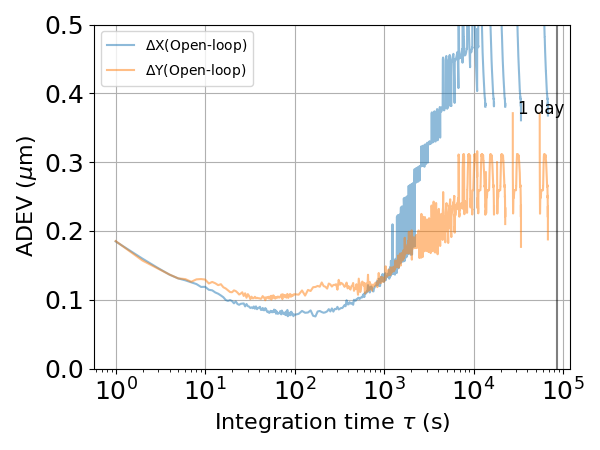

In [52]:
tau_list=np.load(name+'_taulist.npy')
Xlist=np.load(name+'_X.npy')
Ylist=np.load(name+'_Y.npy')

# tau_list2=np.load('20180525_closedloop_taulist.npy')
# Xlist2=np.load('20180525_closedloop_X.npy')
# Ylist2=np.load('20180525_closedloop_Y.npy')


savefig=False
fig, ax = plt.subplots()
fig.set_size_inches(6,4.5)
ax.semilogx(tau_list, Xlist,label=r'$\Delta$X(Open-loop)',alpha=0.5)
ax.semilogx(tau_list, Ylist,label=r'$\Delta$Y(Open-loop)',alpha=0.5)
# ax.semilogx(tau_list2, Xlist2,label=r'$\Delta$X(Closed-loop)',alpha=0.5)
# ax.semilogx(tau_list2, Ylist2,label=r'$\Delta$Y(Closed-loop)',alpha=0.5)
ax.tick_params(labelsize=18)
ax.legend()
plt.axvline(x=86400,color='black',alpha=0.5)
#ax.set_xlim(1,)
#ax.set_title('Allan Deviation (Open-loop vs Closed-loop)',size=)
ax.set_xlabel(r'Integration time $\tau$ (s)',size=16)
ax.set_ylabel(r'ADEV ($\mu$m)',size=16)
#ax.text(10**0,0.3,'Feedback uses last 100 measurements(~ 30 sec)\n from each iteration.\nFeedback cycle time typically ~ 2 min, when activated')
ax.text(10**4.5,0.37,'1 day',size=12)
#ax.axvline(x=60,color='k',alpha=0.3)
ax.set_ylim(0.0,0.5)
ax.grid()
plt.tight_layout()
filename='20180522_AllanDeviation_comparison'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')
